
[Plant Species Classification Report]

                               precision    recall  f1-score   support

                       pepper       0.93      0.96      0.95       297
pepper__bell___bacterial_spot       0.90      0.88      0.89       200
                       potato       0.71      0.50      0.59        24
        potato___early_blight       0.98      0.96      0.97       206
                       tomato       0.96      0.99      0.98       316
        tomato_bacterial_spot       0.94      0.96      0.95       423
          tomato_early_blight       0.85      0.80      0.83       203

                     accuracy                           0.93      1669
                    macro avg       0.90      0.87      0.88      1669
                 weighted avg       0.93      0.93      0.93      1669


[Fertilizer Need Classification Report]

               precision    recall  f1-score   support

     Low Need       0.98      0.97      0.98       654
Moderate Need       0.9

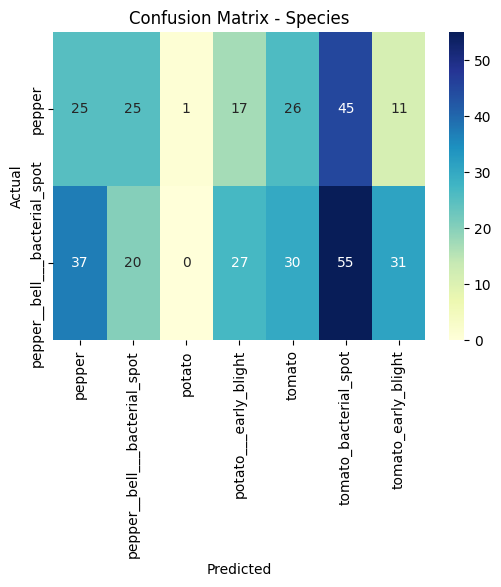

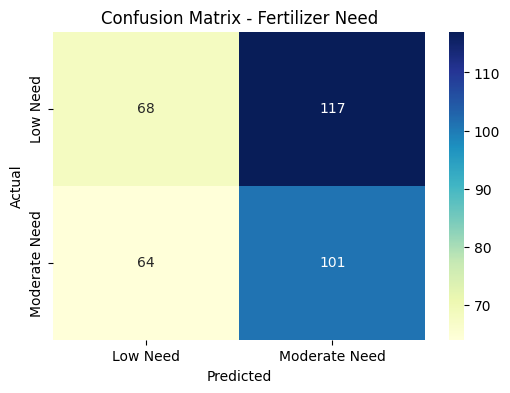

['models/fertilizer_model.pkl']

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from skimage.feature import local_binary_pattern, hog
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

#doing the feature extraction first
def extract_handcrafted_features(image_path):
    img=cv2.imread(image_path)
    img=cv2.resize(img,(128,128))
    features=[]
    avg_color=np.mean(img,axis=(0,1))  #for fertilizer need
    features.extend(avg_color)
    for i in range(3):
        hist=cv2.calcHist([img],[i],None,[16],[0,256])
        hist=cv2.normalize(hist,hist).flatten()
        features.extend(hist)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    #for texture features
    lbp=local_binary_pattern(gray,P=8,R=1,method="uniform")
    lbp_hist, _=np.histogram(lbp.ravel(),bins=np.arange(0,10),range=(0,9))
    lbp_hist=lbp_hist.astype("float")/(lbp_hist.sum()+1e-6)
    features.extend(lbp_hist)
    gray_resized=cv2.resize(gray,(64,128))    #for HOG features
    hog_features=hog(gray_resized,orientations=9,pixels_per_cell=(8,8),
                       cells_per_block=(2,2),block_norm='L2-Hys',visualize=False)
    features.extend(hog_features)
    return np.array(features),avg_color
#foe fertilizer need classification
def label_fertilizer(avg_green):
    if avg_green<55:
        return "High Need"
    elif avg_green<150:
        return "Moderate Need"
    else:
        return "Low Need"

#loading dataset...there are 3 species of plants(potato,tomato,bell pepper)
image_paths=glob("images/*/*.jpg")
data=[]
for path in image_paths:
    species=os.path.basename(os.path.dirname(path))
    if "healthy" in species:
        label=species.split("_")[0].lower()  # potato,tomato,bell pepper
    else:
        label=species.lower()
    features,avg_color=extract_handcrafted_features(path)
    fertilizer_need=label_fertilizer(avg_color[1])
    data.append({
        'path':path,
        'species':label,
        'fertilizer_need':fertilizer_need,
        'features':features
    })
df=pd.DataFrame(data)
X=np.stack(df['features'])
y_species=df['species']
y_fertilizer=df['fertilizer_need']

#training the models....using traditional ML models only
X_train_s,X_test_s,y_train_s,y_test_s=train_test_split(X,y_species,test_size=0.2,random_state=42)  #spltting the data
X_train_f,X_test_f,y_train_f,y_test_f=train_test_split(X,y_fertilizer,test_size=0.2,random_state=42)
species_clf=SVC(kernel='linear')
species_clf.fit(X_train_s,y_train_s)
y_pred_s=species_clf.predict(X_test_s)
fertilizer_clf=RandomForestClassifier(n_estimators=100)
fertilizer_clf.fit(X_train_f, y_train_f)
y_pred_f = fertilizer_clf.predict(X_test_f)
#Evaluating the models
print("\n[Plant Species Classification Report]\n")
print(classification_report(y_test_s,y_pred_s))
print("\n[Fertilizer Need Classification Report]\n")
print(classification_report(y_test_f,y_pred_f))
#Visualizing the results
def plot_confusion_matrix(y_true,y_pred,title):
    cm=pd.crosstab(pd.Series(y_true),pd.Series(y_pred),rownames=['Actual'],colnames=['Predicted'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm,annot=True,fmt='d',cmap='YlGnBu')
    plt.title(title)
    plt.show()
#confusion matrix for both models
plot_confusion_matrix(y_test_s,y_pred_s,"Confusion Matrix - Species")
plot_confusion_matrix(y_test_f,y_pred_f,"Confusion Matrix - Fertilizer Need")

#saving the models
os.makedirs("models",exist_ok=True)
joblib.dump(species_clf,"models/species_model.pkl")
joblib.dump(fertilizer_clf,"models/fertilizer_model.pkl")
